# IMPORTS

In [1]:
import pandas as pd
import numpy as np
import re
import torch
import os
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skimage import io
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer #Pretrained model for text embedding
from torchviz import make_dot
from tqdm import tqdm

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Making the code device-agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Utility Functions

In [6]:
def read_data(fname):
    """
    Reads .csv data and returns a dataframe
    """
    return pd.read_csv(fname,index_col=0)


def clean_text(text):
    """
    Clean text and convert to lowercase
    """
    return re.sub(r'[^\w\s]', '',text).lower()


def Preprocessing(df):
    """
    Wrapper Function to Preprocess the data (replacing NaNs,
    encoding non-numeric columns to numeric values)
    """
    null_cols=df.isnull().sum()*100/len(df)
    null_cols=null_cols[null_cols!=0]
    
    #Replacing NaNs
    for idx,val in null_cols.items():
        if df.dtypes[idx] == object: #replacing with mode if object (i-e string etc)
            df[idx].fillna(df[idx].mode()[0],inplace=True)        
        else: #replacing with average if integer,float etc
            df[idx].fillna(df[idx].mean(),inplace=True)
     
    #Encoding to numeric values
    alpha_cols=df.select_dtypes(include=['object'])
    try:
        df['overall_sentiment']= df['overall_sentiment'].map({'neutral': 0, 'positive': 1,
                                                             'very_positive':1,'negative':2,'very_negative':2})
        df['humour']=df['humour'].map({'not_funny': 0, 'hilarious': 1,'very_funny':1,'funny':1})
        df['sarcasm']=df['sarcasm'].map({'not_sarcastic': 0, 'general': 1,'twisted_meaning':1,'very_twisted':1})
        df['offensive']=df['offensive'].map({'not_offensive': 0, 'very_offensive': 1,'slight':1,'hateful_offensive':1})
        df['motivational']=df['motivational'].map({'not_motivational': 0, 'motivational': 1})
        
        
    except:
        pass
    
    #Cleaning text
    for i in range(len(df)):
        try:
            df1['text_corrected'][i] = clean_text(df1['text_corrected'][i])
        except:
            pass
    
    
def get_max_length_words(df,col):
    """
    Gets max number of words in DF column, for padding purposes
    """
    try:
        return df[col].str.split("\\s+").str.len().max()
    except:
        RaiseError("Invalid Column passed")
        
        
def padding(tensor,length):
    """
    Performs padding
    """
    tensor=torch.tensor(tensor) if not torch.is_tensor(tensor) else tensor
    return torch.nn.functional.pad(tensor,(0, length-tensor.size()[0]))

# Utility Classes

In [7]:
class MemeDataset(Dataset):
    """
    Custom Dataloader for our dataset.
    All credit goes to: https://github.com/aladdinpersson/Machine-Learning-Collection/blame/master/ML/Pytorch/Basics/custom_dataset_txt/loader_customtext.py
    """
    def __init__(self, dataframe, root_dir, pad_length,model,transform = None, freq_threshold = 5):
        self.df = dataframe.copy()
        self.img = self.df['image_name']
        self.pad_len=pad_length
        self.captions = self.df['text_corrected']
        self.root_dir = root_dir
        self.transform = transform
        self.model=model

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        #convert image to 3 channel RGB, as some images in our dataset are >3 channels or <3 channels
        image = Image.open(os.path.join(self.root_dir, self.df.iloc[index, 0])).convert("RGB")
        y_label = torch.tensor(int(self.df.iloc[index, 2]))
        caption = self.captions[index]
        if self.transform:
            image = self.transform(image)   
        padded_text_tensor = padding(self.model.encode(caption,convert_to_tensor=True),self.pad_len)
        return (image, padded_text_tensor, y_label)

# Neural Networks

In [8]:
class NN_img(nn.Module):
    """
    Network for images
    """
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(100*100*3, 1024),
            nn.ReLU(),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,60),
            nn.Tanh(),
            nn.Linear(60,3)
        )
            
    def forward(self, x):
        return self.network(x)

    
class NN_text(nn.Module):
    """
    Network for text
    """
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
        nn.Flatten(),
        nn.Linear(200, 160),
        nn.ReLU(),
        nn.Linear(160,128),
        nn.ReLU(),
        nn.Linear(128,72),
        nn.Tanh(),
        nn.Linear(72,64),
        nn.Tanh(),
        nn.Linear(64,3)
        )

    def forward(self, x):
        return self.network(x)

    
class NN_combined(nn.Module):
    """
    Combined network that uses both image and text network
    """
    def __init__(self, modelA, modelB):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        
        self.network = nn.Sequential(
        nn.Linear(6,64),
        nn.ReLU(),
        nn.Linear(64,32),
        nn.ReLU(),
        nn.Linear(32,16),
        nn.ReLU(),
        nn.Linear(16,6),
        nn.ReLU(),
        nn.Linear(6, 3)
        )
        
    def forward(self, x1, x2):
        x1 = self.modelA(x1)
        x2 = self.modelB(x2)
        x = torch.cat((x1, x2), dim=1)
        return self.network(x)
    
    
def __train__(dataloader, model, loss_fn, optimizer):
    """
    Trains network on trainset
    """
    size = len(dataloader.dataset)
    for batch, (img, txt, y) in enumerate(dataloader):
        img=img.to(device)
        txt=txt.to(device)
        y=y.to(device)
        pred = model(img,txt)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), batch*len(img)
        print(f"loss: {loss:>2f} [{current:>5d}/{size:>2d}]")


def __test__(dataloader, model, loss_fn,acc_list):
    """
    Performs evaluation on testset
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for img, txt, y in dataloader:
            img=img.to(device)
            txt=txt.to(device)
            y=y.to(device)
            pred = model(img,txt)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss/=num_batches
    correct/=size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.2f}%, Average loss: {test_loss:>2f} \n")
    acc_list.append(100*correct)

In [18]:
df=read_data("labels.csv")
df

,image_name,text_ocr,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,hilarious,general,not_offensive,not_motivational,very_positive
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational,very_positive
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,Sam Thorne @Strippin ( Follow Follow Saw every...,very_funny,not_sarcastic,not_offensive,not_motivational,positive
3,image_4.png,10 Year Challenge - Sweet Dee Edition,10 Year Challenge - Sweet Dee Edition,very_funny,twisted_meaning,very_offensive,motivational,positive
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,hilarious,very_twisted,very_offensive,not_motivational,neutral
...,...,...,...,...,...,...,...,...
6987,image_6988.jpg,Tuesday is Mardi Gras Wednesday is Valentine's...,Tuesday is Mardi Gras Wednesday is Valentine's...,very_funny,twisted_meaning,very_offensive,motivational,neutral
6988,image_6989.jpg,MUST WATCH MOVIES OF 2017 ITI Chennai memes MA...,MUST WATCH MOVIES OF 2017 ITI Chennai memes MA...,funny,twisted_meaning,not_offensive,not_motivational,neutral
6989,image_6990.png,LESS MORE TALKING PLANNING SODA JUNK FOOD COMP...,LESS MORE TALKING PLANNING SODA JUNK FOOD COMP...,funny,general,slight,not_motivational,positive
6990,image_6991.jpg,When I VERY have time is a fantasy No one has ...,When I have time is a fantasy. no one has time...,not_funny,twisted_meaning,not_offensive,motivational,very_positive


# TASK A

In [23]:
df1=df[['image_name','text_corrected','overall_sentiment']].copy()
df1

,image_name,text_corrected,overall_sentiment
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,very_positive
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,very_positive
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,positive
3,image_4.png,10 Year Challenge - Sweet Dee Edition,positive
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,neutral
...,...,...,...
6987,image_6988.jpg,Tuesday is Mardi Gras Wednesday is Valentine's...,neutral
6988,image_6989.jpg,MUST WATCH MOVIES OF 2017 ITI Chennai memes MA...,neutral
6989,image_6990.png,LESS MORE TALKING PLANNING SODA JUNK FOOD COMP...,positive
6990,image_6991.jpg,When I have time is a fantasy. no one has time...,very_positive


In [24]:
Preprocessing(df1) #Cleaning NaNs, text, encoding sentiment to numeric values

In [25]:
alpha_len=13 #arbitrary value to add for padding on top of max length sentence
pad_len=get_max_length_words(df1,'text_corrected')+alpha_len

In [27]:
#Loading dataset through our custom dataloader
vector_model=SentenceTransformer('all-MiniLM-L6-v2').to(device) #Pretrained model to generate text embeddings
#All credit to: https://www.sbert.net/docs/pretrained_models.html

dataset = MemeDataset(dataframe = df1, root_dir = './images', pad_length=pad_len,model=vector_model,transform = transforms.Compose(
    [
     transforms.Resize((100, 100)),
     transforms.ToTensor(),
    transforms.Normalize(torch.Tensor([0.5, 0.5, 0.5]), torch.Tensor([0.5, 0.5, 0.5]))
    ]))

In [91]:
#Loading train and test sets
train_set, test_set = torch.utils.data.random_split(dataset, [5000, 1992])
dataloader_train = DataLoader(dataset = train_set, batch_size = 32, shuffle=True)
dataloader_test = DataLoader(dataset = test_set, batch_size = 32, shuffle=True)

In [9]:
#Setting up Neural Networks
net_img = NN_img().to(device) #image network
net_text = NN_text().to(device) #text network 
combined_model = NN_combined(net_img, net_text).to(device) #combined network

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.001)

epochs = 100
acc=list()
for t in tqdm(range(epochs)):
    print(f"Epoch {t+1}\n_______________________________")
    __train__(dataloader_train, combined_model, loss_fn, optimizer)
    __test__(dataloader_test, combined_model, loss_fn,acc)
    if(t>=2 and t%2==0):
        if(acc[t]-acc[t-2]<=0.05):  #Early stopping condition
            print(f"EARLY STOPPING CONDITION FULFILLED\nAccuracy of t-3 iter: {acc[t-2]}\nAccuracy of current iter: {acc[t]}")
            break
        else:
            print(f"Accuracy of t-3 iter: {acc_list[t-2]}\nAccuracy of current iter: {acc[t]}")
print(f"Highest accuracy was: {max(acc)}")

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Epoch 1
_______________________________
loss: 1.031992 [    0/5000]
loss: 1.068702 [   32/5000]
loss: 1.038163 [   64/5000]
loss: 0.996457 [   96/5000]
loss: 1.024765 [  128/5000]
loss: 1.076341 [  160/5000]
loss: 1.042196 [  192/5000]
loss: 1.007920 [  224/5000]
loss: 1.016051 [  256/5000]
loss: 1.072897 [  288/5000]
loss: 0.975816 [  320/5000]
loss: 1.006241 [  352/5000]
loss: 1.019797 [  384/5000]
loss: 1.014388 [  416/5000]
loss: 1.025533 [  448/5000]
loss: 0.962808 [  480/5000]
loss: 0.953734 [  512/5000]
loss: 1.051055 [  544/5000]
loss: 0.981875 [  576/5000]
loss: 1.020705 [  608/5000]
loss: 0.943636 [  640/5000]
loss: 0.903072 [  672/5000]
loss: 0.931526 [  704/5000]
loss: 1.008588 [  736/5000]
loss: 0.995135 [  768/5000]
loss: 0.955873 [  800/5000]
loss: 0.939033 [  832/5000]
loss: 1.063788 [  864/5000]
loss: 0.944923 [  896/5000]
loss: 0.897498 [  928/5000]
loss: 0.931455 [  960/5000]
loss: 0.989457 [  992/5000]
loss: 0.974645 [ 1024/5000]
loss: 0.927003 [ 1056/5000]
loss: 0.

E:\Anaconda3\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


loss: 0.879601 [ 4096/5000]
loss: 0.958779 [ 4128/5000]
loss: 0.808449 [ 4160/5000]
loss: 1.045141 [ 4192/5000]
loss: 0.870819 [ 4224/5000]
loss: 1.063478 [ 4256/5000]
loss: 1.040024 [ 4288/5000]
loss: 0.842173 [ 4320/5000]
loss: 0.955036 [ 4352/5000]
loss: 0.977439 [ 4384/5000]
loss: 0.904296 [ 4416/5000]
loss: 0.893619 [ 4448/5000]
loss: 0.990091 [ 4480/5000]
loss: 0.818657 [ 4512/5000]
loss: 0.925637 [ 4544/5000]
loss: 0.787338 [ 4576/5000]
loss: 0.778378 [ 4608/5000]
loss: 0.937389 [ 4640/5000]
loss: 0.955268 [ 4672/5000]
loss: 0.892484 [ 4704/5000]
loss: 0.772594 [ 4736/5000]
loss: 0.769963 [ 4768/5000]
loss: 0.811333 [ 4800/5000]
loss: 0.929372 [ 4832/5000]
loss: 1.023958 [ 4864/5000]
loss: 0.843331 [ 4896/5000]
loss: 1.021620 [ 4928/5000]
loss: 0.862117 [ 4960/5000]
loss: 0.768020 [ 1248/5000]


  1%|▊                                                                              | 1/100 [01:54<3:09:39, 114.95s/it]

Test Error: 
 Accuracy: 60.04%, Average loss: 0.882743 

Epoch 2
_______________________________
loss: 0.895535 [    0/5000]
loss: 0.821968 [   32/5000]
loss: 0.878481 [   64/5000]
loss: 0.755591 [   96/5000]
loss: 0.826434 [  128/5000]
loss: 1.035736 [  160/5000]
loss: 0.729511 [  192/5000]
loss: 0.877519 [  224/5000]
loss: 1.024269 [  256/5000]
loss: 0.985879 [  288/5000]
loss: 0.917162 [  320/5000]
loss: 1.129575 [  352/5000]
loss: 0.896483 [  384/5000]
loss: 0.837245 [  416/5000]
loss: 0.923291 [  448/5000]
loss: 0.833651 [  480/5000]
loss: 0.895560 [  512/5000]
loss: 1.039373 [  544/5000]
loss: 0.816702 [  576/5000]
loss: 0.799975 [  608/5000]
loss: 0.934125 [  640/5000]
loss: 0.897012 [  672/5000]
loss: 0.855323 [  704/5000]
loss: 0.797001 [  736/5000]
loss: 0.993352 [  768/5000]
loss: 0.836568 [  800/5000]
loss: 0.778206 [  832/5000]
loss: 0.953893 [  864/5000]
loss: 0.897141 [  896/5000]
loss: 0.913267 [  928/5000]
loss: 0.895087 [  960/5000]
loss: 0.933033 [  992/5000]
loss: 0

  2%|█▌                                                                             | 2/100 [03:28<2:46:48, 102.13s/it]

Test Error: 
 Accuracy: 60.04%, Average loss: 0.876219 

Epoch 3
_______________________________
loss: 0.827901 [    0/5000]
loss: 0.884168 [   32/5000]
loss: 0.813949 [   64/5000]
loss: 0.906512 [   96/5000]
loss: 1.009519 [  128/5000]
loss: 0.958257 [  160/5000]
loss: 0.681772 [  192/5000]
loss: 0.899769 [  224/5000]
loss: 1.047392 [  256/5000]
loss: 0.969022 [  288/5000]
loss: 1.018555 [  320/5000]
loss: 0.845807 [  352/5000]
loss: 0.873213 [  384/5000]
loss: 0.959738 [  416/5000]
loss: 0.817579 [  448/5000]
loss: 0.929198 [  480/5000]
loss: 0.844065 [  512/5000]
loss: 0.922699 [  544/5000]
loss: 0.826052 [  576/5000]
loss: 0.898807 [  608/5000]
loss: 0.869184 [  640/5000]
loss: 0.999709 [  672/5000]
loss: 0.697247 [  704/5000]
loss: 0.919812 [  736/5000]
loss: 0.820222 [  768/5000]
loss: 0.819834 [  800/5000]
loss: 0.895978 [  832/5000]
loss: 0.907064 [  864/5000]
loss: 0.863664 [  896/5000]
loss: 0.783761 [  928/5000]
loss: 1.200876 [  960/5000]
loss: 0.883875 [  992/5000]
loss: 1

  2%|█▌                                                                             | 2/100 [05:02<4:06:41, 151.03s/it]

Test Error: 
 Accuracy: 60.04%, Average loss: 0.879272 

EARLY STOPPING CONDITION FULFILLED
Accuracy of t-3 iter: 60.040160642570285
Accuracy of current iter: 60.040160642570285
Highest accuracy was: 60.040160642570285


# Visualizing Architecture

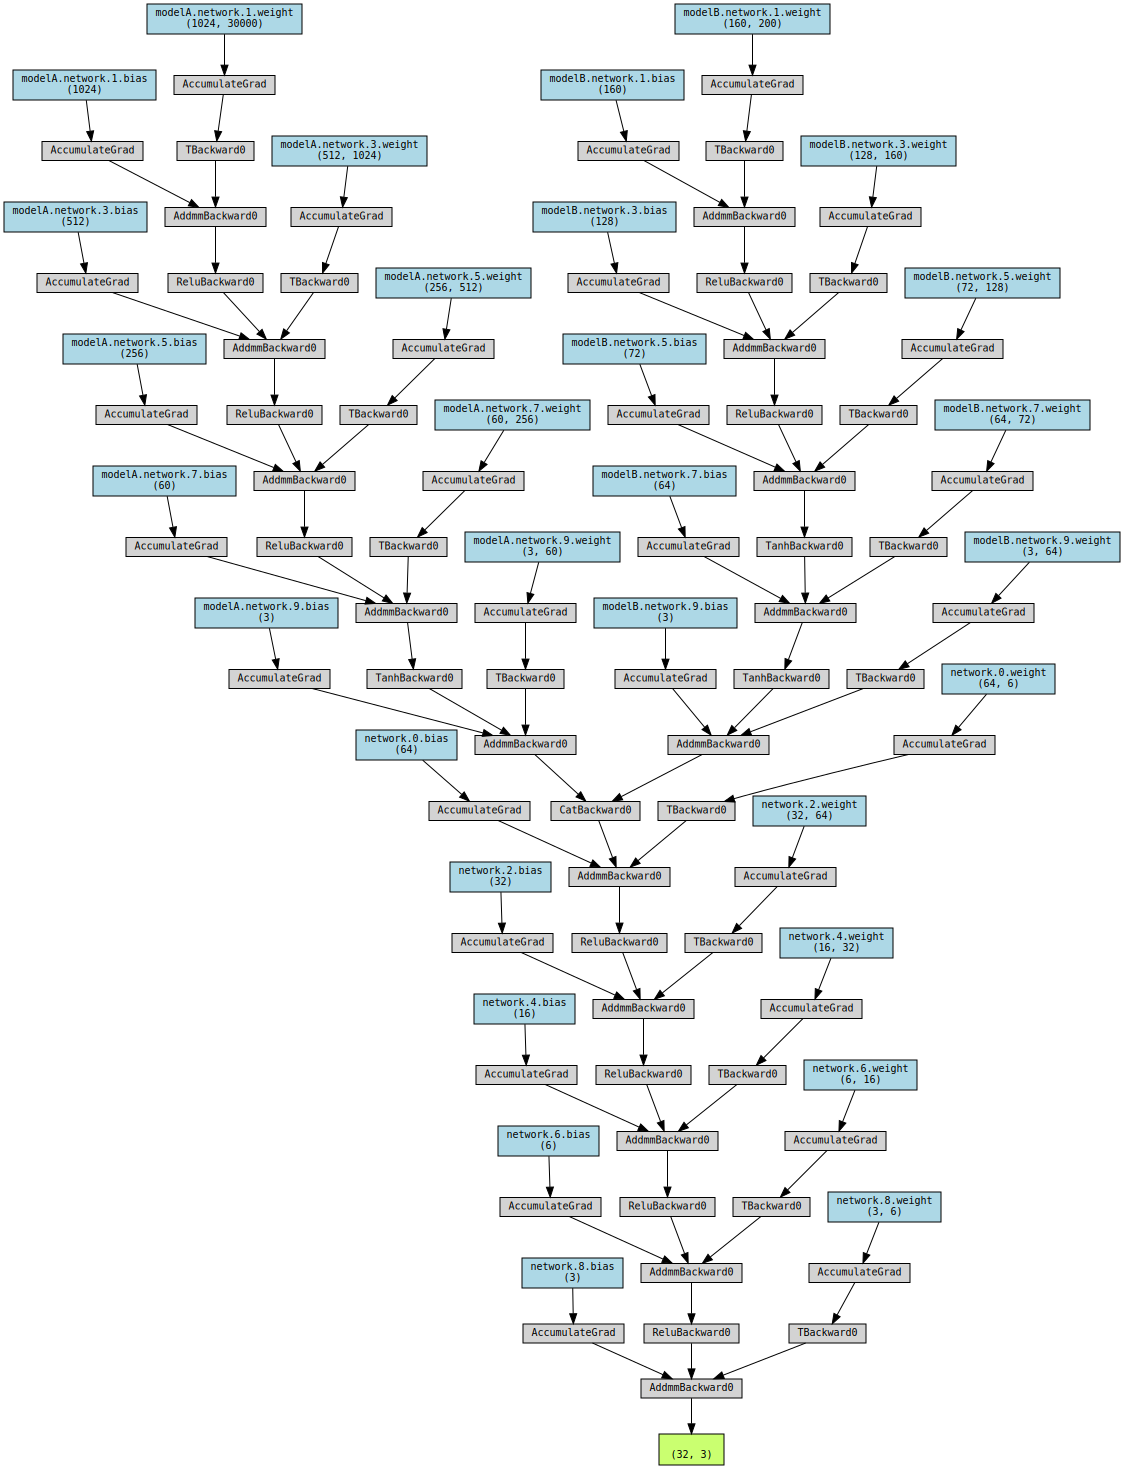

In [94]:
batch = next(iter(dataloader_train))
out=combined_model(batch[0].to(device),batch[1].to(device))
make_dot(out,params=dict(list(combined_model.named_parameters())))

<br><br><br><br>
# TASK B

In [10]:
class MemeDatasetMultiLabel(Dataset):
    """
    Custom Dataloader for our dataset.
    All credit goes to: https://github.com/aladdinpersson/Machine-Learning-Collection/blame/master/ML/Pytorch/Basics/custom_dataset_txt/loader_customtext.py
    """
    def __init__(self, dataframe, root_dir, pad_length,model,transform = None, freq_threshold = 5):
        self.df = dataframe.copy()
        self.img = self.df['image_name']
        self.pad_len=pad_length
        self.captions = self.df['text_corrected']
        self.root_dir = root_dir
        self.transform = transform
        self.model=model

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        #convert image to 3 channel RGB, as some images in our dataset are >3 channels or <3 channels
        image = Image.open(os.path.join(self.root_dir, self.df.iloc[index, 0])).convert("RGB")
        humour = torch.tensor(int(self.df.iloc[index, 2]))
        sarcasm = torch.tensor(int(self.df.iloc[index, 3]))
        offensive = torch.tensor(int(self.df.iloc[index, 4]))
        motivational = torch.tensor(int(self.df.iloc[index, 5]))
        sentiment = torch.tensor(int(self.df.iloc[index, 6]))
        caption = self.captions[index]
        if self.transform:
            image = self.transform(image)   
        padded_text_tensor = padding(self.model.encode(caption,convert_to_tensor=True),self.pad_len)
        return (image, padded_text_tensor, humour,sarcasm,offensive,motivational,sentiment)

In [11]:
class NN_combinedMultiLabel(nn.Module):
    """
    Combined network that uses both image and text network
    """
    def __init__(self, modelA, modelB):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.Linear1 = nn.Linear(6,64)
        self.Linear2 = nn.Linear(64,48)
        self.Linear3 = nn.Linear(48,32)
        self.Linear4 = nn.Linear(32,16)
        self.humour = nn.Linear(16, 2) #humour
        self.sarcasm = nn.Linear(16, 2) #sarcasm
        self.offensive = nn.Linear(16,2) #offensive
        self.motivational = nn.Linear(16, 2) #motivational
        self.sentiment = nn.Linear(16, 3) #sentiment
    
        
    def forward(self, x1, x2):
        x1 = self.modelA(x1)
        x2 = self.modelB(x2)
        x = torch.cat((x1, x2), dim=1)
        x = self.Linear1(x)
        x = self.Linear2(x)
        x = self.Linear3(x)
        x = self.Linear4(x)
        humour = self.humour(x)
        sarcasm = self.sarcasm(x)
        offensive = self.offensive(x)
        motivational = self.motivational(x)
        sentiment = self.sentiment(x)
        return humour, sarcasm, offensive, motivational, sentiment

In [12]:
def __trainMultiLabel__(dataloader, model, loss_fn, optimizer):
    """
    Trains network on trainset
    """
    size = len(dataloader.dataset)
    for batch, (img, txt, humour,sarcasm,offensive,motivational,sentiment) in enumerate(dataloader):
        img=img.to(device)
        txt=txt.to(device)
        humour=humour.to(device)
        sarcasm=sarcasm.to(device)
        offensive=offensive.to(device)
        motivational=motivational.to(device)
        sentiment=sentiment.to(device)
        pred_humour,pred_sarcasm,pred_offensive,pred_motivational,pred_sentiment = model(img,txt)
        
        loss = loss_fn(pred_humour, humour)
        loss +=loss_fn(pred_sarcasm, sarcasm)
        loss += loss_fn(pred_offensive, offensive)
        loss += loss_fn(pred_motivational, motivational)
        loss += loss_fn(pred_sentiment, sentiment)
        #loss /=5
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), batch*len(img)
        print(f"loss: {loss:>2f} [{current:>5d}/{size:>2d}]")


def __testMultiLabel__(dataloader, model, loss_fn,acc_list):
    """
    Performs evaluation on testset
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct_humour,correct_sarcasm,correct_offensive,correct_motivational,correct_sentiment = 0,0,0,0,0,0

    with torch.no_grad():
        for img, txt, humour,sarcasm,offensive,motivational,sentiment in dataloader:
            img=img.to(device)
            txt=txt.to(device)
            humour=humour.to(device)
            sarcasm=sarcasm.to(device)
            offensive=offensive.to(device)
            motivational=motivational.to(device)
            sentiment=sentiment.to(device)
            
            pred_humour,pred_sarcasm,pred_offensive,pred_motivational,pred_sentiment = model(img,txt)
            test_loss+=loss_fn(pred_humour, humour).item()
            test_loss+=loss_fn(pred_sarcasm, sarcasm).item()
            test_loss+=loss_fn(pred_offensive, offensive).item()
            test_loss+=loss_fn(pred_motivational, motivational).item()
            test_loss+=loss_fn(pred_sentiment, sentiment).item()
            
            correct_humour+=(pred_humour.argmax(1)==humour).type(torch.float).sum().item()
            correct_sarcasm+=(pred_sarcasm.argmax(1)== arcasm).type(torch.float).sum().item()
            correct_offensive+=(pred_offensive.argmax(1)==offensive).type(torch.float).sum().item()
            correct_motivational+=(pred_motivational.argmax(1)==motivational).type(torch.float).sum().item()
            correct_sentiment+=(pred_sentiment.argmax(1)==sentiment).type(torch.float).sum().item()

    test_loss/=num_batches
    correct_humour/=size
    correct_sarcasm/=size
    correct_offensive/=size
    correct_motivational/=size
    correct_sentiment/=size
    
    print(f"Test Error: \n")
    print(f"Accuracy Humour: {(100*correct_humour):>0.2f}\n")
    print(f"Accuracy Sarcasm: {(100*correct_sarcasm):>0.2f}\n")
    print(f"Accuracy Offensive: {(100*correct_offensive):>0.2f}\n")
    print(f"Accuracy Motivational: {(100*correct_motivational):>0.2f}\n")
    print(f"Accuracy Sentiment: {(100*correct_sentiment):>0.2f}\n")
    print(f"Average loss: {test_loss:>2f} \n")       
    acc_list.append(max(100*correct_humour,100*correct_sarcasm,100*correct_offensive,100*correct_motivational,100*correct_sentiment))

In [19]:
df2=df[['image_name','text_corrected','humour','sarcasm','offensive','motivational','overall_sentiment']].copy()
Preprocessing(df2)

In [20]:
df2

,image_name,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,1,1,0,0,1
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,0,1,0,1,1
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,1,0,0,0,1
3,image_4.png,10 Year Challenge - Sweet Dee Edition,1,1,1,1,1
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,1,1,1,0,0
...,...,...,...,...,...,...,...
6987,image_6988.jpg,Tuesday is Mardi Gras Wednesday is Valentine's...,1,1,1,1,0
6988,image_6989.jpg,MUST WATCH MOVIES OF 2017 ITI Chennai memes MA...,1,1,0,0,0
6989,image_6990.png,LESS MORE TALKING PLANNING SODA JUNK FOOD COMP...,1,1,1,0,1
6990,image_6991.jpg,When I have time is a fantasy. no one has time...,0,1,0,1,1


In [28]:
dataset = MemeDatasetMultiLabel(dataframe = df2, root_dir = './images', pad_length=pad_len,model=vector_model,transform = transforms.Compose(
    [
     transforms.Resize((100, 100)),
     transforms.ToTensor(),
    transforms.Normalize(torch.Tensor([0.5, 0.5, 0.5]), torch.Tensor([0.5, 0.5, 0.5]))
    ]))

In [29]:
#Loading train and test sets
train_set, test_set = torch.utils.data.random_split(dataset, [5000, 1992])
dataloader_train = DataLoader(dataset = train_set, batch_size = 32, shuffle=True)
dataloader_test = DataLoader(dataset = test_set, batch_size = 32, shuffle=True)

In [30]:
#Setting up Neural Networks
net_img = NN_img().to(device) #image network
net_text = NN_text().to(device) #text network 
combined_model = NN_combinedMultiLabel(net_img, net_text).to(device) #combined network

In [83]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.001)

epochs = 100
acc=list()
for t in tqdm(range(epochs)):
    print(f"Epoch {t+1}\n_______________________________")
    __trainMultiLabel__(dataloader_train, combined_model, loss_fn, optimizer)
    __testMultiLabel__(dataloader_test, combined_model, loss_fn,acc)
    if(t>=2 and t%2==0):
        if(acc[t]-acc[t-2]<=0.05):  #Early stopping condition
            print(f"EARLY STOPPING CONDITION FULFILLED\nAccuracy of t-3 iter: {acc[t-2]}\nAccuracy of current iter: {acc[t]}")
            break
        else:
            print(f"Accuracy of t-3 iter: {acc_list[t-2]}\nAccuracy of current iter: {acc[t]}")
print(f"Highest accuracy was: {max(acc)}")

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Epoch 1
_______________________________
loss: 3.181851 [    0/5000]
loss: 3.192149 [   32/5000]
loss: 3.193506 [   64/5000]
loss: 3.422945 [   96/5000]
loss: 3.160816 [  128/5000]
loss: 3.198177 [  160/5000]
loss: 3.183076 [  192/5000]
loss: 3.094862 [  224/5000]
loss: 3.022176 [  256/5000]
loss: 3.397007 [  288/5000]
loss: 3.321777 [  320/5000]
loss: 3.012135 [  352/5000]
loss: 3.344561 [  384/5000]
loss: 3.181353 [  416/5000]
loss: 3.101958 [  448/5000]
loss: 3.341607 [  480/5000]
loss: 3.390997 [  512/5000]
loss: 3.228394 [  544/5000]
loss: 3.520459 [  576/5000]
loss: 3.369275 [  608/5000]
loss: 3.588180 [  640/5000]
loss: 3.099011 [  672/5000]
loss: 3.408998 [  704/5000]
loss: 3.376512 [  736/5000]
loss: 3.288741 [  768/5000]
loss: 2.938505 [  800/5000]
loss: 3.427382 [  832/5000]
loss: 3.187208 [  864/5000]
loss: 3.153762 [  896/5000]
loss: 3.380699 [  928/5000]
loss: 3.091266 [  960/5000]
loss: 3.676898 [  992/5000]
loss: 3.412807 [ 1024/5000]
loss: 2.989572 [ 1056/5000]
loss: 3.

E:\Anaconda3\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  1%|▊                                                                               | 1/100 [01:35<2:38:08, 95.84s/it]

Test Error: 

Accuracy Humour: 75.75

Accuracy Sarcasm: 79.52

Accuracy Offensive: 63.40

Accuracy Motivational: 65.01

Accuracy Sentiment: 58.68

%, Average loss: 3.270131 

Epoch 2
_______________________________
loss: 3.074965 [    0/5000]
loss: 3.230849 [   32/5000]
loss: 3.516552 [   64/5000]
loss: 3.557749 [   96/5000]
loss: 3.561820 [  128/5000]
loss: 2.906014 [  160/5000]
loss: 3.165698 [  192/5000]
loss: 3.398494 [  224/5000]
loss: 3.123908 [  256/5000]
loss: 3.397817 [  288/5000]
loss: 3.241474 [  320/5000]
loss: 3.409682 [  352/5000]
loss: 3.481389 [  384/5000]
loss: 2.927086 [  416/5000]
loss: 3.179989 [  448/5000]
loss: 3.151728 [  480/5000]
loss: 3.278608 [  512/5000]
loss: 3.310737 [  544/5000]
loss: 2.942817 [  576/5000]
loss: 3.488342 [  608/5000]
loss: 3.376359 [  640/5000]
loss: 3.217922 [  672/5000]
loss: 3.505288 [  704/5000]
loss: 3.087891 [  736/5000]
loss: 3.579529 [  768/5000]
loss: 3.057596 [  800/5000]
loss: 3.328974 [  832/5000]
loss: 3.391850 [  864/5000]
l

  2%|█▌                                                                              | 2/100 [03:11<2:36:34, 95.86s/it]

Test Error: 

Accuracy Humour: 75.75

Accuracy Sarcasm: 79.52

Accuracy Offensive: 63.40

Accuracy Motivational: 65.01

Accuracy Sentiment: 58.68

%, Average loss: 3.280907 

Epoch 3
_______________________________
loss: 3.358717 [    0/5000]
loss: 3.511050 [   32/5000]
loss: 3.456989 [   64/5000]
loss: 3.492413 [   96/5000]
loss: 3.065030 [  128/5000]
loss: 3.131469 [  160/5000]
loss: 3.242973 [  192/5000]
loss: 3.150727 [  224/5000]
loss: 3.211489 [  256/5000]
loss: 2.671563 [  288/5000]
loss: 3.078994 [  320/5000]
loss: 3.583281 [  352/5000]
loss: 3.484960 [  384/5000]
loss: 3.199497 [  416/5000]
loss: 2.911459 [  448/5000]
loss: 3.640718 [  480/5000]
loss: 3.371685 [  512/5000]
loss: 3.000285 [  544/5000]
loss: 3.117225 [  576/5000]
loss: 3.465537 [  608/5000]
loss: 3.075216 [  640/5000]
loss: 3.003437 [  672/5000]
loss: 3.009940 [  704/5000]
loss: 3.221038 [  736/5000]
loss: 3.220543 [  768/5000]
loss: 3.266614 [  800/5000]
loss: 3.493443 [  832/5000]
loss: 3.166718 [  864/5000]
l

  2%|█▌                                                                             | 2/100 [04:44<3:52:26, 142.31s/it]

Test Error: 

Accuracy Humour: 75.65

Accuracy Sarcasm: 79.52

Accuracy Offensive: 62.35

Accuracy Motivational: 65.01

Accuracy Sentiment: 58.68

%, Average loss: 3.342691 

EARLY STOPPING CONDITION FULFILLED
Accuracy of t-3 iter: 79.51807228915662
Accuracy of current iter: 79.51807228915662
Highest accuracy was: 79.51807228915662


### Visualizing Multilabel Architecture

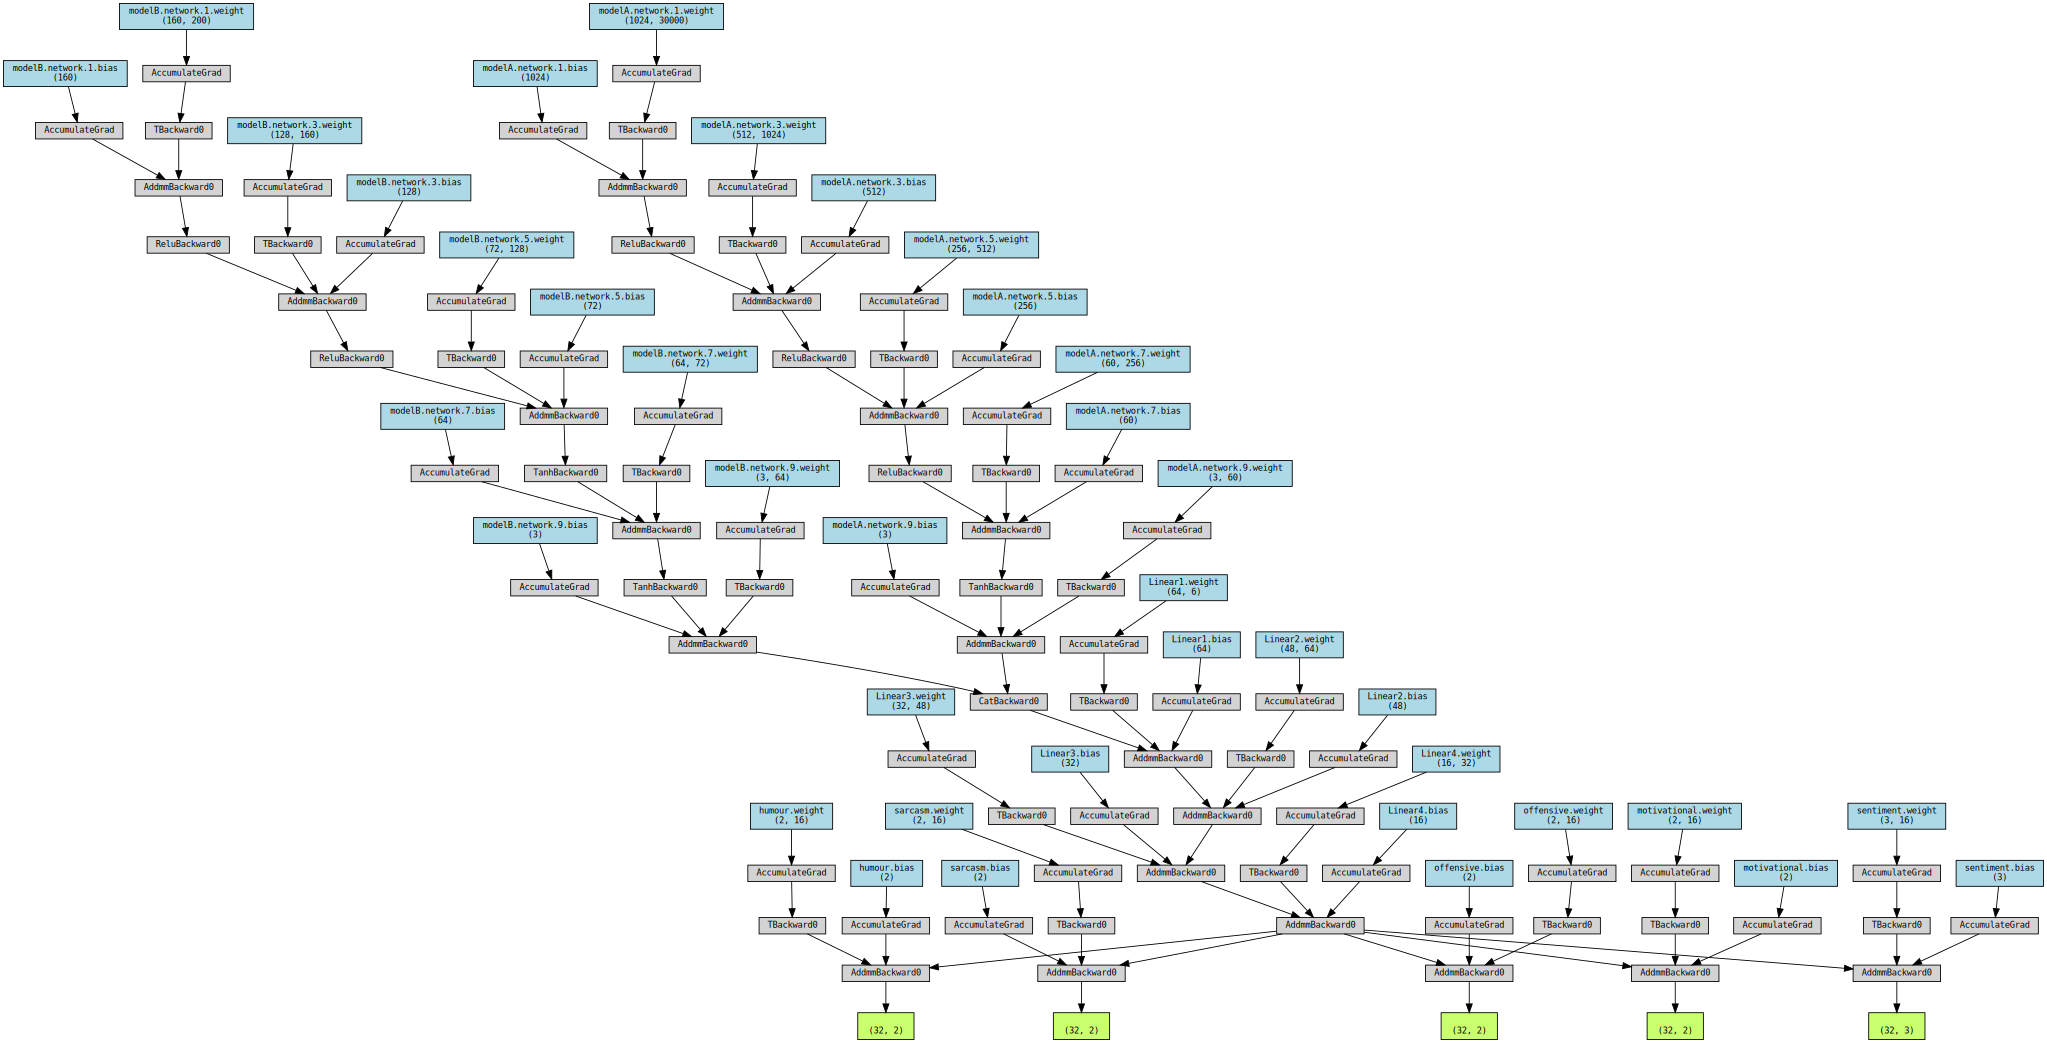

In [101]:
batch = next(iter(dataloader_train))
out=combined_model(batch[0].to(device),batch[1].to(device))
make_dot(out,params=dict(list(combined_model.named_parameters())))

In [103]:
#saving model
torch.save({
    'model_state_dict': combined_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    },"multilabel_weights.pt")

In [39]:
#loading model
combined_model = NN_combinedMultiLabel(net_img, net_text).to(device) #combined network
weights_file=torch.load("multilabel_weights.pt")
combined_model.load_state_dict(weights_file['model_state_dict'])

<All keys matched successfully>